# Demonstration Notebook
This is a Notebook designed to demonstrate how to use some of the different functions in the code.
It doesn't show everything but shows some of the core features. First we need to import pyNab itself.

First we need to import pyNab itself.
You may see various messages during this import related to features being enabled or disabled. 

In [1]:
# # from matplotlib.pyplot import axis
# import numpy as np
# # import h5py as hd
# import pandas as pd
import sys

nabPath = "/Users/seeker/TNwork/nabonlineanalysis/nabpyinstallations/pyNab/src"
deltaRicePath = "/Users/seeker/TNwork/nabonlineanalysis/nabpyinstallations/deltarice/build/lib.macosx-11.0-arm64-cpython-312/"

sys.path.append(deltaRicePath)
sys.path.append(nabPath)

import nabPy as Nab

In [11]:
# import pyNab as Nab

pyNab has a variety of optional features that are enabled if they are detected on your computer. 
- GPU support through cupy
- FPGA emulation through fxpmath fixed precision library
- Accelerated FFT operations with pyFFTW (or GPU if available)
- Custom HDF5 compression through nabCompression.h5 (soon to be renamed)

## Introduction to pyNab and How it Works

pyNab is built around a series of different modules/classes. 
Each module/class serves a distinct purpose motivated by data in the Nab experiment

- pyNab.py: Defines DataRun Class
    - Loads in all sub-modules to combine all of the data from a single run
    - waveformFileClass.py: pyNab.wf : Defines waveformFile Class
        - .singl, .pulsr, .noise, .coinc
        - Loads in waveform files specifically
        - Uses Dask/Numpy to load in the waveforms themselves
        - Uses Pandas to handle the headers for each waveform
    - temperatureFileClass.py : pyNab.tmf : temperatureFile Class
        - .tmprt
        - Loads in the FPGA temperatures
    - parameterFileClass.py : pyNab.pf : parameterFile Class
        - .param
        - Parses the .param output file from Manitoba data to load in pixel maps and other useful run parameters
        - For ORNL datasets, parses the HDF5 parameter group
    - eventFileClass.py: pyNab.ef : Defines eventFile Class
        - .event
        - Loads in the events as identified by the DAQ. Not particularly useful for Manitoba data due to formatting issues
        - Will be updated with more functionality for ORNL datasets
    - triggerFileClass.py: pyNab.tf : Defines triggerFile Class
        - .trigg
        - This class handles the triggers returned from the FPGAs
        - also implements some basic cutting routines
    - resultFileClass.py : pyNab.rf : resultFile Class
        - Handles the results from certain analysis functions in waveformFileClass
        - Basically wraps around pandas dataframes with some extra functionality thrown in 
            - In particular cutting routines
            - Some basic plotting routines and some other functionality as well
    There are also other files that are responsible for file formatting and data processing.

    - basicFunctions.py : bf
        - It's name is a lie. This is where all the analysis code is defined
    - gpuFunctions.py : pyNab.bf.gpu
        - Where the GPU functions are defined. Currently doesn't have much, work in progress
    - fileFormats.py : pyNab.ff
        - This is where the binary file formats are defined for the structured binary files such as from Manitoba

## Opening a whole Run of Data

The Class DataRun handles opening entire sets of data that were output from the DAQ. The user is expected to pass this class a directory to search for files, and the run number. This code will automatically open ALL files associated with this run that are in the directory. Missing files will cause errors.

In [12]:
runNumber = 1374
directory = 'C:\\Users\\David\\Documents\\datafiles\\pNabDemoData\\'

In [13]:
runWithEvents = Nab.DataRun(directory, runNumber)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\David\\Documents\\datafiles\\pNabDemoData\\'

You'll probably notice this takes a bit to run. This is normally due to the eventFile Class. This class is very inefficient for the Manitoba dataset because of file format issues. If you want to avoid that, try this instead.

In [14]:
runWithoutEvents = Nab.DataRun(directory, runNumber, ignoreEventFile = True)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\David\\Documents\\datafiles\\pNabDemoData\\'

Now you have the same set of data, but one of them has the events and the other doesn't.

Note that while these do use some RAM, they don't use nearly as much RAM as the whole file size. This is because of the use of Dask to handle the waveform files. These files are only loaded when you specifically request that data to be processed, saving memory and allowing you to handle very large amounts of data easily. 

In [15]:
runWithEvents = None
runWithoutEvents = None

## Getting information from the files

Plenty of information is available through the class itself

In [36]:
# runNumber = 1375
# directory = 'G:\\Shared drives\\Nab\\Manitoba Tests\\Manitoba Data\\01-26-2022 Sn113 Partial Bias Scan + 3hr -300V Bias Run\\'
# run = Nab.DataRun(directory, runNumber, ignoreEventFile = True)

file = "../../../nabanalysis/TearDropAnalysis/data/Run3516_1.h5"
run = Nab.File(file)

In [39]:
print('There are ', run.singleWaves().numWaves, ' singles waveforms, each is ', run.singleWaves().wavelength, ' long')
print('There are ', run.coincWaves().numWaves, ' coincidence waveforms, each is ', run.coincWaves().wavelength, ' long')
print('There are ', run.pulsrWaves().numWaves, ' pulser waveforms, each is ', run.pulsrWaves().wavelength, ' long')
print('There are ', run.noiseWaves().numWaves, ' noise waveforms, each is ', run.noiseWaves().wavelength, ' long')
print('There are ', run.triggers().numtrigs, ' triggers')

There are  271900  singles waveforms, each is  7000  long
There are  32382  coincidence waveforms, each is  7000  long
There are  0  pulser waveforms, each is  0  long
There are  0  noise waveforms, each is  0  long
There are  312159  triggers


Metadata such as the filter parameters is available through the parameters class.

In [18]:
parameters = run.parameterFile()
print(parameters.FilterParameters.dtype)
print(parameters.FilterParameters)

[('threshold', '<i4'), ('M', '<i4'), ('Trap F.T.', '<u2'), ('Trap R.T.', '<u2'), ('Dead Time', '<u2')]
[(500000,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (    25,   625, 20, 625, 700) (   200,   625, 20, 625, 700)
 (   200,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (    25,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (    25,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (    25,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (    25,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (   200,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (    25,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (   200,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (    25,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (   200,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (   200,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (    25,   625, 20, 625, 700) (    25,   625, 20, 625, 700)
 (   200,   625, 20, 625, 700) (    25,   6

Also information such as how the coincidence logic was configured is available

In [19]:
parameters.BoardChannelPixelMap

array([(  0,   90), (  1,  110), (  2,  111), (  3,  120), (  4,  127),
       (  5,  119), (  6,   89), (  7,   99), (  8,  108), (  9,  126),
       ( 10,  117), ( 11,  125), ( 12,   98), ( 13,  115), ( 14,  123),
       ( 15,  109), ( 16,  118), ( 17,   76), ( 18,  124), ( 19,   97),
       ( 20,   88), ( 21,  107), ( 22,  122), ( 23,  116), ( 24,  121),
       ( 25,   96), ( 26,  105), ( 27,   87), ( 28,  113), ( 29,   95),
       ( 30,  104), ( 31,  114), ( 32,   75), ( 33,  106), ( 34,   74),
       ( 35,   84), ( 36,   86), ( 37,   85), ( 38,   71), ( 39,   83),
       ( 40,   94), ( 41,   61), ( 42,   72), ( 43,   64), ( 44,   62),
       ( 45,   73), ( 46,   60), ( 47,   63), ( 48,   48), ( 49,   46),
       ( 50,   58), ( 51,   49), ( 52,   38), ( 53,   35), ( 54,   59),
       ( 55,   47), ( 56,   50), ( 57,   25), ( 58,   26), ( 59,   28),
       ( 60,   51), ( 61,   16), ( 62,   37), ( 63,   36), ( 64,   27),
       ( 65,   18), ( 66,   17), ( 67,    1), ( 68,    9), ( 69,

If you want to access the raw original data for the classes, this can be done via a few helper functions.

For waveform files, the following functions are what you'll want to use

In [20]:
run.singleWaves().headers()

,result,bc,timestamp,req,event type,hit type,blank,eventid,checksum,board,channel,unix timestamp,pixel
0,1,36,2831945755628,2831958309208,0,0,0,357948,3333473000,4,4,4.225448e+17,86
1,1,43,2831945354042,2831958411946,0,0,0,357949,1137190818,5,3,4.225448e+17,64
2,1,43,2831945358342,2831958437084,0,0,0,357950,1068507152,5,3,4.225448e+17,64
3,1,43,2831945383376,2831958462216,0,0,0,357951,2973315351,5,3,4.225448e+17,64
4,1,43,2831945482906,2831958487358,0,0,0,357952,3365219399,5,3,4.225448e+17,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271895,1,160,2838754090662,2838758184940,0,0,0,651749,2796843575,20,0,4.225449e+17,1048
271896,1,65,2838754395266,2838758232184,0,0,0,651761,1405480031,8,1,4.225449e+17,18
271897,1,144,2838754557496,2838758201574,0,0,0,651763,2453883050,18,0,4.225449e+17,1075
271898,1,107,2838754722962,2838758204850,0,0,0,651764,1448323481,13,3,4.225449e+17,68


In [21]:
run.singleWaves().waves()

dask.array<astype, shape=(271900, 7000), dtype=float32, chunksize=(9073, 7000), chunktype=numpy.ndarray>

In [22]:
run.singleWaves().waves()[0].compute()

array([-24., -27., -32., ...,  -2., -26., -49.], dtype=float32)

Notice the different return types. 

.headers() returns the headers as a Pandas DataFrame

.waves() returns the waveforms as a Dask Array. This is synonomous with a Numpy array. If you want a Numpy array instead, simply add .compute()

run.singleWaves().waves().compute()

That will load the waveform data into RAM so hopefully you have enough memory. 

If you aren't sure what is available to you, try the following:
    Let tab completion tell you what is available.
Then if you find what you're looking for, use the question mark function to see what it does. 

In [23]:
run.pulsrWaves().

SyntaxError: invalid syntax (1082497932.py, line 1)

In [ ]:
run.singleWaves().headers?

Object `headers` not found.


In [ ]:
run.singleWaves().headers

Note that for this you NEED to go to the original class structure. So for pulsrWaves(), this object is a waveform file. So you have to do Nab.wf.waveformFile.BLAHBLAH
and then replace BLAHBLAH with the function of interest.

In [ ]:
Nab.wf.waveformFile.headers?

Signature: Nab.wf.waveformFile.headers(self, orig=False)
Docstring:
Returns the waveform headers as a Pandas DataFrame.

Parameters
----------
orig: bool
        If orig is true, return the whole original DataFrame without cuts
        If orig is false, return the DataFrame with cuts

Returns
-------
headers: Pandas DataFrame
File:      c:\users\david\documents\datafilereadingscripts\waveformfileclass.py
Type:      function


The difference is pretty obvious. Otherwise these are identical. If you don't plan on using the event information, I'd recommend using the ignoreEventFile flag.

If you want to see what boards and channels were recorded in a waveform file, along with how many times they were recorded, you can do that with the following command. The mapping variable tells you what board and channel each waveform was in the order they occured. 

In [24]:
bcs = run.singleWaves().bcs
print('board channels', bcs[0])
print('mapping', bcs[1])
print('counts', bcs[2])

bcs = run.triggers().bcs
print('board channels', bcs[0])
print('mapping', bcs[1])
print('counts', bcs[2])

board channels [1, 2, 3, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 121, 124, 127, 131, 133, 134, 135, 136, 137, 138, 141, 144, 145, 146, 147, 149, 153, 155, 157, 158, 159, 160, 162, 163, 164, 168, 170, 172, 174, 175, 176, 180, 183, 186, 188, 189, 192, 193, 194, 201, 204, 211, 212, 216, 217, 220, 226, 227, 228, 229]
mapping [ 24  31  31 ...  89  76 125]
counts [   730   1479    228     99    629    556    366    336    825   1619
   1973    173    400   1128   1016    249   1562    110    333    494
    358    298   5338    329    761    693    220    308    310   1363
   1764 136427    404    273    281     55    164    294   3110    402
   5812    312   1666    383    447    941    280    219   4256   5824
   6231   5466   1

If you want to see the mapping between board/channel to pixel, that can be found in the parameter file. The first number is the board * 8 + channel number and the second is the pixel number in each element in the list

In [25]:
run.plotHitLocations(sourceFile = 'singles', cmap = 'cividis', showNum=True, showVal = True, alpha=0.8, rounding=1, size=1.3)

TypeError: File.plotHitLocations() got an unexpected keyword argument 'cmap'

## Analysis Functionality

### Applying Data Cuts and Energy Extraction

When you want to run analysis, it's often desirable to only look at part of the data file. That way you don't spend as much time running possibly complicated analysis over data you aren't interested in. 

Based on the pixel map above, it looks like pixel 87 has some data we might want so let's look at that.

In [26]:
run.singleWaves().resetCuts()
run.singleWaves().defineCut('pixel', '=', 88)
headers = run.singleWaves().headers()
print(headers)

        result  bc      timestamp            req  event type  hit type  blank  \
40           1  20  2831952094196  2831962307900           0         0      0   
127          1  20  2831962117850  2831968368268           0         0      0   
226          1  20  2831962585852  2831970559876           0         0      0   
300          1  20  2831970939406  2831973670116           0         0      0   
377          1  20  2831968994314  2831975527814           0         0      0   
...        ...  ..            ...            ...         ...       ...    ...   
271353       1  20  2838739927266  2838744380808           0         0      0   
271423       1  20  2838742320956  2838745936868           0         0      0   
271531       1  20  2838747704808  2838749093688           0         0      0   
271562       1  20  2838746007214  2838749180754           0         0      0   
271812       1  20  2838751962998  2838755272914           0         0      0   

        eventid    checksum

Now when you use either the .headers() or the .waves() functions, they will only return data that passes the cuts applied. Note that we can apply multiple cuts by simply using defineCut again. It's always recommended to use resetCuts() whenever you enter a new cell as the waveformFile object will remember the previous cuts applied until you reset them. 

Any parameter in the header information can be cut on. The cut functionality can be found below.

In [27]:
Nab.bf.defineCut?

Signature: Nab.bf.defineCut(data, category, operator=None, optionA=None, optionB=None)
Docstring:
This function defines a cut to apply to the dataset. 
You can only cut on data available in the headers

Parameters
----------
data: dask.DataFrame
        the DataFrame that contains the dataset
category : str
        the category to cut on. Must be a category in the waveform header
        To check available categories, call yourWaveformFile.headerType
        Also available categories:
                'pixel': requires a pixel map to be defined in the class
                'custom': unique operation that allows the user to pass a custom map of 
                        the data to request instead of determining the map within the class
                        This changes the behavior of operator
                'ca45Corruption': cut that is based on the conditions Noah described in his thesis.
                        This removes the corruption issues from that version of the DAQ.
     

With this subset applied, we can look at the energy histogram for this pixel. 

Depending on your PC, this may take a while to complete. For large datasets this can be particularly taxing. The code is designed to use ALL of your CPU resources and will run in parallel by default.

In [28]:
results = run.singleWaves().determineEnergyTiming(method='trap', params=[1250, 50, 1250])

Now we can plot this data and see what is there

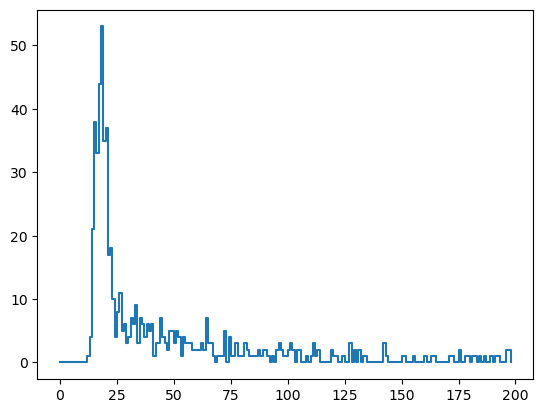

In [29]:
results.hist('energy', bins = Nab.np.arange(0, 200))
results.show()

Not too much for this dataset unfortunately. Mostly just noise.

Note that the bins parameter expects a Numpy array defining the bin edges to be passed in. 

Most of the plotting functionality built into the resultFile class is just calling matplotlib.pyplot behind the scenes. For more plotting funcitonality, I'd recommend just parsing the results object itself.

If you want to get fancy with it, we can do additional cuts to this. Let's look at a high amplitude waveform

In [30]:
results.resetCuts()
results.defineCut('energy', '>', 100)

In [31]:
results.data()

,result,bc,timestamp,req,event type,hit type,blank,eventid,checksum,board,channel,unix timestamp,pixel,energy,t0
1267,1,20,2831993707430,2831997943420,0,0,0,360651,4236088531,2,4,4.225448e+17,88,101.039693,3566.0
1572,1,20,2832001239538,2832004458906,0,0,0,360967,973362895,2,4,4.225448e+17,88,1654.080267,3483.0
2351,1,20,2832020580676,2832024872930,0,0,0,361849,4006338146,2,4,4.225448e+17,88,1173.930343,3483.0
5157,1,20,2832093922226,2832096176172,0,0,0,364964,720318928,2,4,4.225448e+17,88,1120.612784,5403.5
7861,1,20,2832158221018,2832161226442,0,0,0,367868,2277569398,2,4,4.225448e+17,88,622.644707,3493.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263871,1,20,2838553095330,2838556808460,0,0,0,643120,1662792485,2,4,4.225449e+17,88,1197.070314,3483.0
266255,1,20,2838612202616,2838615041140,0,0,0,645634,1441711580,2,4,4.225449e+17,88,400.508918,3486.0
266510,1,20,2838618082136,2838621344472,0,0,0,645925,1168741639,2,4,4.225449e+17,88,151.647508,3490.0
267876,1,20,2838652665486,2838655605108,0,0,0,647443,3284628054,2,4,4.225449e+17,88,490.742624,3483.0


Now my results class has the indices saved of the waveforms in the file that satisfy BOTH the original pixel 88 cut AND the energy > 100 cut.

To look at waveforms above that energy range, do this.

In [32]:
run.singleWaves().defineCut('custom', results.returnCut())

waves = run.singleWaves().waves()

Now the only waves in that waves container are large amplitude waveforms

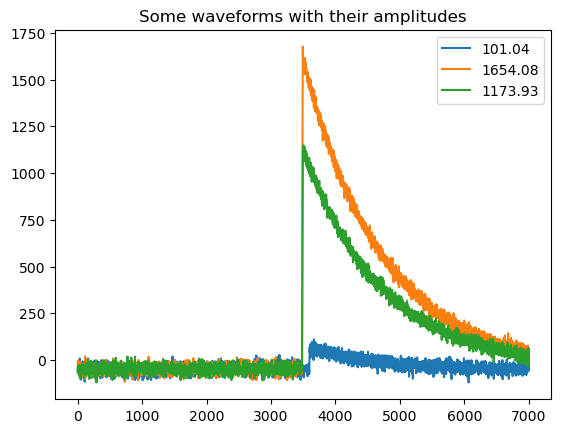

In [33]:
for i in range(3):
	Nab.plt.plot(waves[i], label=str(round(results.data()['energy'].iloc[i], 2)))
Nab.plt.title('Some waveforms with their amplitudes')
Nab.plt.legend()
Nab.plt.show()

In [34]:
run.singleWaves().resetCuts()
run.singleWaves().defineCut('pixel', '=', 88)
headers = run.singleWaves().headers()
print(headers)

        result  bc      timestamp            req  event type  hit type  blank  \
40           1  20  2831952094196  2831962307900           0         0      0   
127          1  20  2831962117850  2831968368268           0         0      0   
226          1  20  2831962585852  2831970559876           0         0      0   
300          1  20  2831970939406  2831973670116           0         0      0   
377          1  20  2831968994314  2831975527814           0         0      0   
...        ...  ..            ...            ...         ...       ...    ...   
271353       1  20  2838739927266  2838744380808           0         0      0   
271423       1  20  2838742320956  2838745936868           0         0      0   
271531       1  20  2838747704808  2838749093688           0         0      0   
271562       1  20  2838746007214  2838749180754           0         0      0   
271812       1  20  2838751962998  2838755272914           0         0      0   

        eventid    checksum

### Noise Analysis

Let's look at that same pixel and get a sense of what the noise was like

In [35]:
run.noiseWaves().resetCuts()
run.noiseWaves().defineCut('pixel', '=', 88)

spectra = run.noiseWaves().generatePowerSpectra()

AttributeError: 'NoneType' object has no attribute 'dtypes'

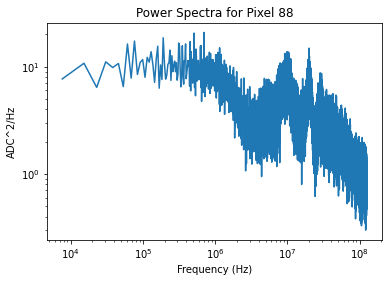

In [ ]:
Nab.plt.plot(spectra[0][1:], spectra[1][1:])
Nab.plt.yscale('log')
Nab.plt.xscale('log')
Nab.plt.xlabel('Frequency (Hz)')
Nab.plt.ylabel('ADC^2/Hz')
Nab.plt.title('Power Spectra for Pixel 88')
Nab.plt.show()

Note that the first bin was removed. The first bin is the 0th frequency bin. This bin is often a very small number and can mess with the automatic scaling of the plot so I tend to remove it to make plots simpler. It's not that the data isn't important, just the plots don't look nice easily with it included.

In [ ]:
waves = run.singleWaves().waves()

In [ ]:
jjjj

dask.array<astype, shape=(271900, 7000), dtype=float32, chunksize=(9073, 7000), chunktype=numpy.ndarray>

In [ ]:
import numpy as np

In [ ]:
subrundata = {
    "top": {
        "trigger": np.random.randint(100, size=127),
        "single": np.random.randint(100, size=127),
        "coincidence": np.random.randint(100, size=127),
        "pulser": np.random.randint(100, size=127),
        "noise": np.random.randint(100, size=127),
        },
    "bottom": {
        "trigger": np.random.randint(100, size=127),
        "single": np.random.randint(100, size=127),
        "coincidence": np.random.randint(100, size=127),
        "pulser": np.random.randint(100, size=127),
        "noise": np.random.randint(100, size=127),
        },


    }       

In [ ]:
det = ['top', 'bottom']
evttype = ['single', 'trigger', 'coincidence', 'pulser', 'noise']
for i in det:
    for j in evttype:
        print(i,j)
        try:
            subrundata[i][j] = run.plotHitLocations(j, det=i)
        except:
            subrundata[i][j] = np.zeros(127) 
        print(subrundata[i][j][:10])

top single
[5466    0    0    0    0  319    0 4557 1929 2236]
top trigger
[5940    0    0    0    0  381    0 5010 2126 2536]
top coincidence
[392   0   0   0   0  47   0 360 156 238]
top pulser
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
top noise
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
bottom single
[0 0 0 0 0 0 0 0 0 0]
bottom trigger
[0 0 0 0 0 0 0 0 0 0]
bottom coincidence
[0 0 0 0 0 0 0 0 0 0]
bottom pulser
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
bottom noise
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
run.triggers().triggers()

,timestamp,bc,energy,pixel
0,2831482619036,12,81,98
1,2831482619104,15,42,109
2,2831482619080,20,37,88
3,2831482535342,38,239,71
4,2831482620728,35,572,84
...,...,...,...,...
312154,2838757650362,65,36,18
312155,2838757721870,65,65496,18
312156,2838757742540,69,65498,8
312157,2838757749058,69,65501,8


In [ ]:
    def getbcpixmap(self):
        bctopixmap = self._thisRun.parameterFile().BoardChannelPixelMap
        self.bcpixmap = {}
        for i in bctopixmap:
            self.bcpixmap[int(i[0])] = int(i[1])
        self.vectorized_map = np.vectorize(self.bcpixmap.get) 

    def getevtarr(ele):
        tstamp = ele[7][0]
        ptof = (ele[7][0] - ele[8][0]) * 4e-9 / 1e-6  # in microseconds
        pener = ele[7][2]
        evttype = ele[1]
        numtrig = ele[4]
        ppix = ele[7][1]
        epix = ele[8][1]
        eener = ele[8][2] + ele[9][2] + ele[10][2] + ele[11][2] + ele[12][2]
        return(np.array([evttype, numtrig, ptof, pener, ppix, eener, epix,tstamp]))

    def get_coinc_df(events):
        evtarr = np.array(list(map(getevtarr, events)))
        # evtarr[:,4]= self.vectorized_map(evtarr[:,4])
        # evtarr[:,6]= self.vectorized_map(evtarr[:,6])
        evtarr = evtarr[evtarr[:,0] == 1]
        evtdf = pd.DataFrame(evtarr)
        evtdf.columns = ['evttype', 'numtrig', 'ptof', 'pener', 'ppix', 'eener', 'epix','tstamp']
        return(evtdf)   


In [10]:
import numpy as np
import pandas as pd
import holoviews as hv

hv.extension("matplotlib")
# df = get_coinc_df(events)
file = "../../../nabanalysis/TearDropAnalysis/data/Run3516_1.h5"
file = "../../../nabanalysis/TearDropAnalysis/data/Run"
file = "//Users/seeker/TNwork/nabonlineanalysis/datafiles/hdf5files/Aug2023/Run3588_3.h5"
run = Nab.File(file)
events = run.eventFile().getevents()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [11]:
class MData:
    def __init__(self) -> None:
        self._thisRun = None

    def getbcpixmap(self):
        bctopixmap = self._thisRun.parameterFile().BoardChannelPixelMap
        self.bcpixmap = {}
        for i in bctopixmap:
            self.bcpixmap[int(i[0])] = int(i[1])
        self.vectorized_map = np.vectorize(self.bcpixmap.get)

    def make_event_array(self, ele):
        tstamp = ele[7][0]
        ptof = (ele[7][0] - ele[8][0]) * 4e-9 / 1e-6  # in microseconds
        pener = ele[7][2]
        evttype = ele[1]
        numtrig = ele[4]
        ppix = ele[7][1]
        epix = ele[8][1]
        eener = ele[8][2] + ele[9][2] + ele[10][2] + ele[11][2] + ele[12][2]
        return np.array([evttype, numtrig, ptof, pener, ppix, eener, epix, tstamp])

    def get_eventarray(self):
        self.getbcpixmap()
        self.events = self._thisRun.eventFile().getevents()
        self.evtarr = np.array(list(map(self.make_event_array, self.events)))
        self.evtarr[:, 4] = self.vectorized_map(self.evtarr[:, 4])
        self.evtarr[:, 6] = self.vectorized_map(self.evtarr[:, 6])
        return self.evtarr

    def get_coinc_df(self):
        self.get_eventarray()
        evtarr = self.evtarr[self.evtarr[:, 0] == 1]
        evtdf = pd.DataFrame(evtarr)
        evtdf.columns = [
            "evttype",
            "numtrig",
            "ptof",
            "pener",
            "ppix",
            "eener",
            "epix",
            "tstamp",
        ]
        # evtdf['time'] = (evtdf.tstamp - evtdf.tstamp.min())*4e-9
        return evtdf

data = MData()
data._thisRun = run

AttributeError: 'NoneType' object has no attribute 'parameterFile'

In [14]:
df = data.get_coinc_df()
# df.head()
# run.filenames()

AttributeError: 'MData' object has no attribute 'evtarr'

In [68]:
df.tail()

,evttype,numtrig,ptof,pener,ppix,eener,epix,tstamp,time
3438,1.0,2.0,13.912,46.0,65.0,951.0,144.0,1.007972e+13,77.399810
3439,1.0,2.0,14.096,26.0,17.0,1193.0,194.0,1.007972e+13,77.410755
3440,1.0,2.0,25.680,34.0,58.0,510.0,146.0,1.007972e+13,77.416694
3441,1.0,2.0,17.192,33.0,84.0,1180.0,236.0,1.007973e+13,77.458529
3442,1.0,2.0,14.264,29.0,25.0,1787.0,184.0,1.007973e+13,77.472315


:Scatter   [x]   (y)
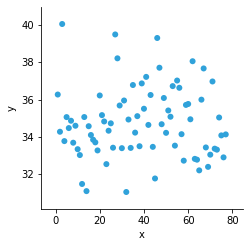

In [66]:
# tbin = np.linspace(df.tstamp.min(), df.tstamp.max(), 100)
tbin = np.arange(df.time.min(), df.time.max(), 1)
# tbin
data = df.groupby(pd.cut(df.time, tbin)).pener.mean().to_numpy()
hv.Scatter((tbin[1:], data))

In [63]:
# data['tstamp']
# data.to_numpy()
print(len(data), len(tbin))

99 100


In [52]:
# data.index.to_numpy()

python(74287) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Scatter   [x]   (y)
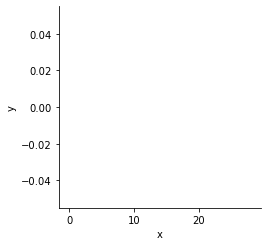

In [59]:
# hv.Scatter(np.arange(9))

In [67]:
events[4]

np.void((357492, 1, 1, 7000, 2, 28000, 1, (2831923013430, 43, 26), (2831922996464, 56, 1606), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)), dtype=[('eventid', '<u4'), ('type', 'i1'), ('number of waveforms', 'u1'), ('waveform length', '<u2'), ('number of triggers', '<i2'), ('event request size', '<u4'), ('requested?', 'u1'), ('Trig0', [('timestamp', '<u8'), ('bc', 'u1'), ('energy', '<u2')]), ('Trig1', [('timestamp', '<u8'), ('bc', 'u1'), ('energy', '<u2')]), ('Trig2', [('timestamp', '<u8'), ('bc', 'u1'), ('energy', '<u2')]), ('Trig3', [('timestamp', '<u8'), ('bc', 'u1'), ('energy', '<u2')]), ('Trig4', [('timestamp', '<u8'), ('bc', 'u1'), ('energy', '<u2')]), ('Trig5', [('timestamp', '<u8'), ('bc', 'u1'), ('energy', '<u2')])])

In [2]:
import numpy as np
np.arange(2.3, 50.3, 1)

array([ 2.3,  3.3,  4.3,  5.3,  6.3,  7.3,  8.3,  9.3, 10.3, 11.3, 12.3,
       13.3, 14.3, 15.3, 16.3, 17.3, 18.3, 19.3, 20.3, 21.3, 22.3, 23.3,
       24.3, 25.3, 26.3, 27.3, 28.3, 29.3, 30.3, 31.3, 32.3, 33.3, 34.3,
       35.3, 36.3, 37.3, 38.3, 39.3, 40.3, 41.3, 42.3, 43.3, 44.3, 45.3,
       46.3, 47.3, 48.3, 49.3])